## Clustering visualization

This notebook will be used for the visualization of the subspace-defining cluster using different techniques and under different clusterings.

We will load an existing clustering and then visualize it using different techniques.

In [12]:
# Include and load packages, config files
import numpy as np
import simlr_ad
import pandas as pd
from utils.data_utils import load_all_data
from utils.utils import compute_simlr, feat_ranking, estimate_number_clusters, estimate_number_clusters_cimlr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Parameters of the procedure
clusters = 3
rd_seed = 1714                                          # Random seed for experiment replication

# Paths
existing_cluster = True                               # Compute the clustering again or use an existing one
cluster_path = "results/cimlr4/"   # Path of the existing cluster, if applicable
covariate_path = "data/useddata_homo_abeta_plasma_meta.csv"
feature_path = "data/UCSDVOL.csv"                     # Path of the feature path (.csv)

covariate_data, cov_names, feature_data, feature_names = load_all_data(covariate_path, feature_path, data_type='sfsdfs')

feature_data['DX'] = covariate_data.DX_bl.values

covariate_data.to_csv('data/data_normalized.csv')

if existing_cluster:
    # Load existent
    c_data = pd.read_csv(cluster_path + 'cluster_data.csv')
    c_data.reset_index(inplace=True)
    ## Load S, F data
    S = np.load(cluster_path + 'S_matrix.npy')
    ydata = np.load(cluster_path + 'ydata_matrix.npy')
    F = np.load(cluster_path + 'F_matrix.npy')
    alpha = np.load(cluster_path + 'alpha.npy')
else:
    # Compute base clustering
    y_b, S, F, ydata, alpha = compute_simlr(
        np.array(covariate_data[cov_names]), clusters)

# Preprocess S matrix

S_old = (S - min(S.flatten())) / (max(S.flatten())-min(S.flatten())) 
S = (1-S_old)
from sklearn.metrics.pairwise import euclidean_distances
S_euclidean = euclidean_distances(covariate_data[cov_names], covariate_data[cov_names])
S_euc_new = (1-S_euclidean)


How to determine number of clusters: 
    
* First, based on the method from the paper.

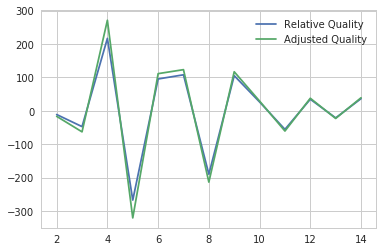

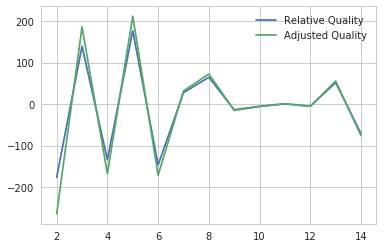

In [12]:
# Visualize possible number of clusters
K1, K2, n_list = estimate_number_clusters(np.array(covariate_data[cov_names]))

plt.plot(n_list, K1, label='Relative Quality')
plt.plot(n_list, K2, label='Adjusted Quality')
plt.legend()
plt.show()

K1, K2, n_list = estimate_number_clusters_cimlr(np.array(covariate_data[cov_names]))

plt.plot(n_list, K1, label='Relative Quality')
plt.plot(n_list, K2, label='Adjusted Quality')
plt.legend()
plt.show()

* Using the elbow method

Text(0.5,1,'Elbow for KMeans clustering')

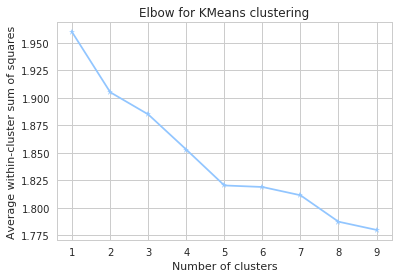

In [13]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
cluster_range = range( 1, 10 )

## New method
centroids = []
data = np.array(covariate_data[cov_names])
for n in cluster_range:
    # Calculate clustering for n clusters
    # Compute base clustering
    y_b, S, F, ydata, alpha = compute_simlr(data,  n)
    # Compute centroids
    centroids.append([np.mean(data[y_b == i], axis=0) for i in range(1,n+1)])
    
# Compute distances to centroids
D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/data.shape[0] for d in dist]

# elbow curve
fig = plt.figure()
plt.plot(cluster_range, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

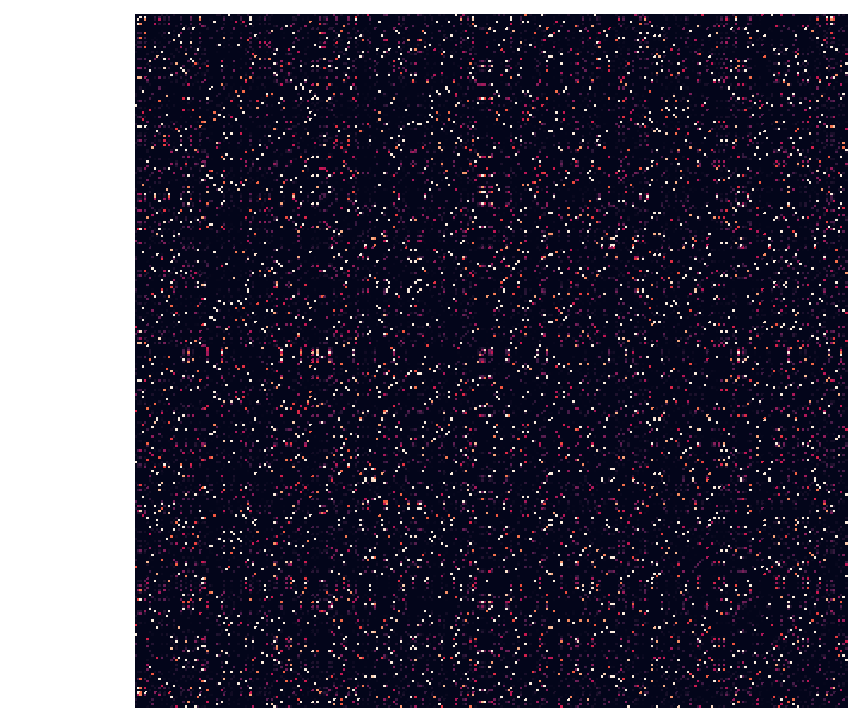

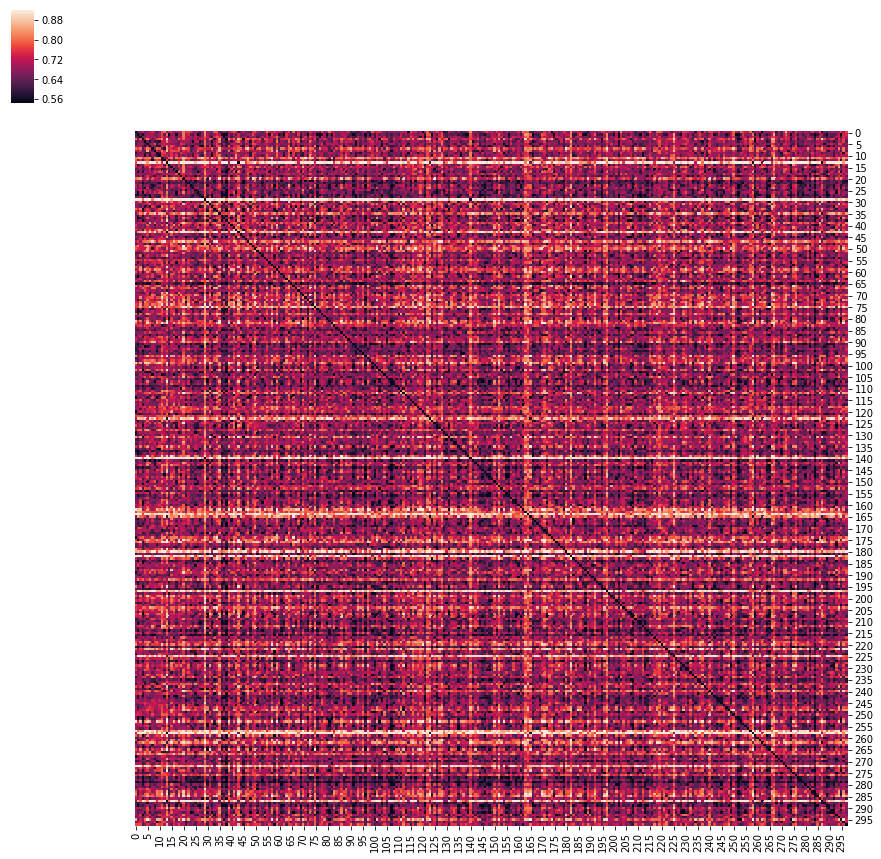

In [11]:
## Visualize the similarity matrix

# Sort the similarity matrices using the clustering labels
c_data_sorted = c_data.sort_values(['C'])
index = c_data_sorted.index.values

S_old = S_old[index, :]
S_old = S_old[:, index]

S_euclidean = S_euclidean[index, :]
S_euclidean = S_euclidean[:, index]

cm = sns.clustermap(S_old, col_cluster=False, row_cluster=False, robust=True,
               method='average', metric='seuclidean', standard_scale=1, figsize=(15, 15), xticklabels=False, yticklabels=False, cbar=False)
cm.cax.set_visible(False)
col = cm.ax_col_dendrogram.get_position()
cm.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height*0.01])
plt.savefig(cluster_path+'figures/Cluster_Cimlr.png')
plt.show()


sns.clustermap(S_euclidean, col_cluster=False, row_cluster=False, robust=True,
               method='average', metric='seuclidean', standard_scale=1, figsize=(15, 15))
plt.savefig(cluster_path+'figures/Cluster_euclidean.png')
plt.show()


In [15]:
## Use t-SNE to visualize the clusters
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# test different parameters!
ts = TSNE(n_components=2, perplexity = 25.0, early_exaggeration = 30.0, learning_rate = 100.0, metric='precomputed')
space = ts.fit_transform(S)
plt.scatter(space[:, 0], space[:, 1], c=c_data['C'].values)
plt.axis('tight')
plt.savefig(cluster_path+'figures/simlr_tsne.png')
plt.show()


ValueError: All distances should be positive, the precomputed distances given as X is not correct

In [ ]:
## Visualize feature importance

# First, create feature importance
feat_imp = []
for i in range(len(cov_names)):
    values = alpha[15*i:15*i+15]
    feat_imp.append(sum(values))

print(len(feat_imp)) 
print(len(cov_names))

# Print the figure
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

values = pd.DataFrame(data={"names": cov_names,
                            "values": feat_imp})


values["norm_values"] = (feat_imp - np.min(feat_imp)) / (np.max(feat_imp)-np.min(feat_imp))
plt.figure(figsize=(10,35))

sns.set_color_codes("pastel")
sns.barplot(x="values", y="names", data=values,
           label="Importance", color="b")

# sns.set_color_codes("muted")
# sns.barplot(x="norm_values", y="names", data=values,
#             label="Normalized importance", color="b")

sns.despine(left=True, bottom=True)
plt.savefig(cluster_path+'figures/cluster_importance.png')